<a href="https://colab.research.google.com/github/zxhom26/SharkPaleobiologyResearch/blob/main/Image_Processing_and_EFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up Github Environment

In [41]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from functools import reduce

In [2]:
from google.colab import userdata
token = userdata.get('shark_paleo_token')

In [3]:
%cd /content
!git config --global user.name "zxhom26"
!git config --global user.email "zxhom26@gmail.com"
!git clone https://github.com/zxhom26/SharkPaleobiologyResearch.git
!git remote set-url origin https://{token}@github.com/zxhom26/SharkPaleobiologyResearch.git
%cd /content/SharkPaleobiologyResearch

/content
Cloning into 'SharkPaleobiologyResearch'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 140 (delta 88), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 49.93 MiB | 11.60 MiB/s, done.
Resolving deltas: 100% (88/88), done.
fatal: not a git repository (or any of the parent directories): .git
/content/SharkPaleobiologyResearch


In [34]:
def bw_image(raw_image):
  gray = cv2.imread(raw_image, cv2.IMREAD_GRAYSCALE)
  thresh_val, bw = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
  return bw

In [43]:
def load_images():
  bw_images = []
  for img_path in glob.glob('*.JPG'):
    bw = bw_image(img_path)
    assert bw is not None
    bw_images.append(bw)
  return bw_images

In [44]:
%cd /content/SharkPaleobiologyResearch/Java/
java = load_images() # Load Java shark images
%cd /content/SharkPaleobiologyResearch/Bull/
bull = load_images() # Load Bull shark images
%cd /content/SharkPaleobiologyResearch/

/content/SharkPaleobiologyResearch/Java
/content/SharkPaleobiologyResearch/Bull
/content/SharkPaleobiologyResearch


120.0


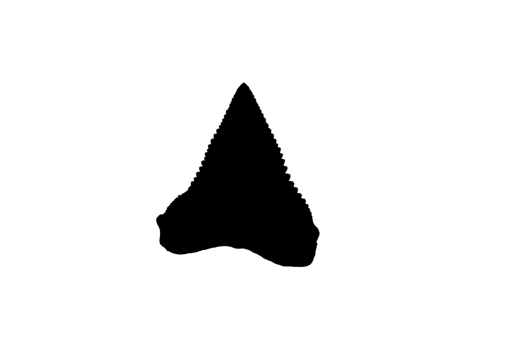

In [15]:
# Load image in grayscale (reduces RGB channels to 1 brightness val)
img = cv2.imread('Bull/BU13-1-1.JPG', cv2.IMREAD_GRAYSCALE)

# Threshold or edge detection (OR cv2.THRESH_BINARY)
thresh_val, bw = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)

# Plot
plt.imshow(bw, cmap='gray')
plt.axis('off')
plt.show()